In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.stats import ortho_group
import os
import sys
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from skimage.transform import AffineTransform, warp
from torch.autograd import Variable

from scipy import stats

from __future__ import print_function
#%matplotlib inline
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image, ImageDraw
import traceback

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
# https://github.com/jacobaustin123/wgan-pytorch

# Number of workers for dataloader
workers = 2
# Batch size during training
batch_size = 128
# Size of z latent vector (i.e. size of generator input)
nz = 100

In [ ]:
class TextDataset(Dataset):
    
    def __init__(self, data_name, val = False):
        super().__init__()
        data = np.load(data_name)
        if not val:
            self.reviewText = torch.Tensor(data[:30000, :-1].copy())
            self.overall = torch.Tensor(data[:30000, -1].copy())
        else:
            self.reviewText = torch.Tensor(data[30000:33987, :-1].copy())
            self.overall = torch.Tensor(data[30000:33987, -1].copy())

    def __getitem__(self, idx):
        return self.reviewText[idx], self.overall[idx]
        
    def __len__(self):
        return len(self.overall)

In [ ]:
is_data = TextDataset("Industrial_and_Scientific_5_emb.npy")
lb_data = TextDataset("Luxury_Beauty_5_emb.npy")

is_val_data = TextDataset("Industrial_and_Scientific_5_emb.npy", val=True)
lb_val_data = TextDataset("Luxury_Beauty_5_emb.npy", val=True)

is_loader = torch.utils.data.DataLoader(is_data, batch_size=512, num_workers=2)
lb_loader = torch.utils.data.DataLoader(lb_data, batch_size=512, num_workers=2)

is_val_loader = torch.utils.data.DataLoader(is_val_data, batch_size=512, num_workers=2)
lb_val_loader = torch.utils.data.DataLoader(lb_val_data, batch_size=512, num_workers=2)
print(len(is_data), len(lb_data))

30000 30000


In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.main = nn.Sequential(
            nn.BatchNorm1d(96),
            nn.Linear(96, 40),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(40, 40),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(40, 96),
            nn.Sigmoid(),
            nn.Linear(96, 96)
        )

    def forward(self, input):
        input = self.main(input)
        return input

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(96, 25),
            nn.BatchNorm1d(25),
            nn.Dropout(),
            nn.ReLU(True),
            nn.Linear(25, 25),
            nn.BatchNorm1d(25),
            nn.Dropout(),
            nn.ReLU(True),
            nn.Linear(25, 25),
            nn.BatchNorm1d(25),
            nn.Dropout(),
            nn.ReLU(True),
            nn.Linear(25, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netE = Encoder().cuda()
netE.apply(weights_init)
netC = Classifier().cuda()
netC.apply(weights_init)

Classifier(
  (main): Sequential(
    (0): Linear(in_features=96, out_features=25, bias=True)
    (1): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=25, out_features=25, bias=True)
    (5): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=25, out_features=25, bias=True)
    (9): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.5, inplace=False)
    (11): ReLU(inplace=True)
    (12): Linear(in_features=25, out_features=1, bias=True)
    (13): Sigmoid()
  )
)

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()


# Setup Adam optimizers for both G and D
optimizerE = optim.Adam(netE.parameters())
optimizerC = optim.Adam(netC.parameters(), lr=1e-3)

In [ ]:
def get_prior_A_for_classifier(x1, x2):
    assert x1.size(0) == x2.size(0)
    y = torch.cat([torch.full((x1.size(0),), -1, dtype=torch.float, device = x1.device), 
                   torch.full((x2.size(0),),  1, dtype=torch.float, device = x2.device)])
    x = torch.cat([x1, x2])

    ksi = Variable(torch.rand((x.size(0),), device = x.device), requires_grad=True)
    lam = Variable(torch.rand(96, device = x.device), requires_grad=True)

    opt = torch.optim.SGD([{"params": ksi, "lr": 0.1},
                           {"params": lam, "lr": 0.1},
                           ])

    for _ in range(100):
        opt.zero_grad()
        
        _A = torch.diag(lam) + (x.t() * (2 * torch.sigmoid(ksi) - 1) / (2 * ksi)).mm(x)
        v = torch.mv(x.t(), y) / 2
        sum = (2 * F.logsigmoid(ksi) + (2 * torch.sigmoid(ksi) - 1) * ksi / 2 - ksi).sum()
        sum += torch.log(lam).sum() - torch.logdet(_A) + torch.mv(torch.linalg.inv(_A), v).dot(v)

        (-sum).backward()
        opt.step()

    return lam.detach()

In [ ]:
def train_all():
    netE.train(); netC.train(); 
    E_losses = []
    C_losses = []
    lams = []
    iters = 0
    num_epochs = 15

    print("Starting Training Loop...")
    # For each epoch
    try:
        for epoch in range(num_epochs):

            # For each batch in the dataloader
            for i, (is_data, lb_data) in enumerate(zip(is_loader, lb_loader), 0):

                ############################
                # (1) Update C network: maximize log(C(E(z_0))) + log(1 - C(E(z_1)))
                ###########################
                ## Train with all-real batch
                netC.zero_grad()
                # Format batch
                is_data = is_data[0].cuda()
                lb_data = lb_data[0].cuda()

                is_label = torch.full((is_data.size(0),), 0, dtype=torch.float).cuda()
                lb_label = torch.full((lb_data.size(0),), 1, dtype=torch.float).cuda()
                # Forward pass real batch through C
                lb_emb_data = netE(lb_data)

                lb_output = netC(lb_emb_data.detach()).view(-1)
                is_output = netC(is_data.detach()).view(-1)
                # Calculate loss on 0-domain batch
                errC = criterion(is_output, is_label) + criterion(lb_output, lb_label)
                # Calculate gradients for D in backward pass
                errC.backward()
                optimizerC.step()
                
                ############################
                # (2) Update E network: maximize log(D(G(z))) - MSE_reconstrunction
                ###########################
                netE.zero_grad()
                # Since we just updated C, perform another forward pass of all-fake batch through C
                lb_output = netC(lb_emb_data).view(-1)
                is_output = netC(is_data).view(-1)

                # Calculate E's loss based on this output
                errE = criterion(is_output, lb_label) + criterion(lb_output, is_label)
                # Calculate gradients for E, D
                errE.backward()
                # Update E, D
                optimizerE.step()

                # Output training stats
                if i % 60 == 0:
                    print('[%d/%d][%d/%d]\tLoss_C: %.4f\tLoss_E: %.4f'
                        % (epoch, num_epochs, i, len(is_loader),
                            errC.item(), errE.item()))

                # Save Losses for plotting later
                E_losses.append(errE.item())
                C_losses.append(errC.item())
                
                # Check how the generator is doing by saving G's output on fixed_noise
                # if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                #     with torch.no_grad():
                #         fake = netG(fixed_noise).detach().cpu()
                #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                iters += 1
            

            (is_data, lb_data) = next(iter( zip(is_val_loader, lb_val_loader) ))

            is_data = is_data[0].cuda()
            lb_data = lb_data[0].cuda()
            lb_emb_data = netE(lb_data)
            
            l = get_prior_A_for_classifier(is_data.detach(), lb_emb_data.detach())
            lams.append(l.cpu().detach().numpy().copy())
    except BaseException:
        traceback.print_exc()
    finally:
        return E_losses, C_losses, lams

res = train_all()
E_losses = res[0]; C_losses = res[1]; lams = res[2]

Starting Training Loop...
[0/15][0/59]	Loss_C: 1.4694	Loss_E: 1.4467
[1/15][0/59]	Loss_C: 1.3808	Loss_E: 1.4295
[2/15][0/59]	Loss_C: 1.3955	Loss_E: 1.3994
[3/15][0/59]	Loss_C: 1.3891	Loss_E: 1.3852
[4/15][0/59]	Loss_C: 1.3851	Loss_E: 1.3894
[5/15][0/59]	Loss_C: 1.3792	Loss_E: 1.3947
[6/15][0/59]	Loss_C: 1.3903	Loss_E: 1.3950
[7/15][0/59]	Loss_C: 1.3876	Loss_E: 1.3922
[8/15][0/59]	Loss_C: 1.3900	Loss_E: 1.3864
[9/15][0/59]	Loss_C: 1.3848	Loss_E: 1.3887
[10/15][0/59]	Loss_C: 1.3862	Loss_E: 1.3897
[11/15][0/59]	Loss_C: 1.3850	Loss_E: 1.3920
[12/15][0/59]	Loss_C: 1.3869	Loss_E: 1.3907
[13/15][0/59]	Loss_C: 1.3796	Loss_E: 1.3907
[14/15][0/59]	Loss_C: 1.3847	Loss_E: 1.3904


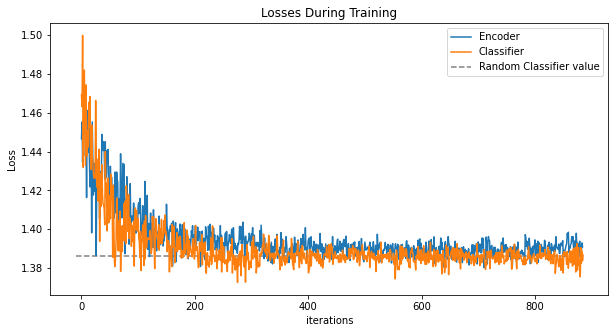

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Losses During Training")
plt.plot(E_losses,label="Encoder")
plt.plot(np.linspace(0, len(E_losses), len(C_losses)), C_losses,label="Classifier")
# plt.plot(D1_losses,label="Decoder 1")
# plt.plot(D2_losses,label="Decoder 2")
plt.hlines(1.3863, -10, len(E_losses), linestyles='--', alpha=0.5, label='Random Classifier value')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
torch.save(netE.state_dict(), 'netE_KL')
torch.save(netC.state_dict(), 'netC_KL')

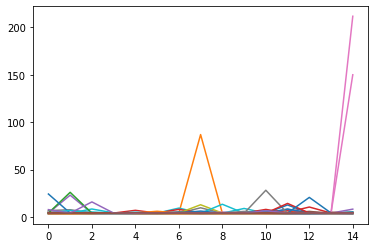

In [ ]:
_ = plt.plot(lams)

In [ ]:
class SimpleRegressor(nn.Module):
    def __init__(self):
        super(SimpleRegressor, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(96, 25),
            nn.BatchNorm1d(25),
            nn.Dropout(),
            nn.ReLU(True),
            nn.Linear(25, 25),
            nn.BatchNorm1d(25),
            nn.Dropout(),
            nn.ReLU(True),
            nn.Linear(25, 25),
            nn.BatchNorm1d(25),
            nn.Dropout(),
            nn.ReLU(True),
            nn.Linear(25, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
model = SimpleRegressor().cuda()
model_criterion = nn.MSELoss()

model_optimizer = optim.Adam(model.parameters())

In [ ]:
def calc_Aduenko_p_value(x1, y1, x2, y2):
    w_hat1 = torch.linalg.inv(x1.t().mm(x1)).mv(x1.t().mv(y1))
    w_hat2 = torch.linalg.inv(x2.t().mm(x2)).mv(x2.t().mv(y2))

    w_dif = w_hat1 - w_hat2
    s = torch.linalg.inv(x1.t().mm(x1)) + torch.linalg.inv(x2.t().mm(x2))
    value = torch.linalg.inv(s).mv(w_dif).dot(w_dif)

    return stats.chi2(96).cdf(value.item())

In [ ]:
def train_model():
    model.train()
    netE.eval()
    is_losses = []
    lb_losses = []
    iters = 0
    num_epochs = 50

    print("Starting Training Loop...")
    # For each epoch
    try:
        for epoch in range(num_epochs):
            for i, (is_data, lb_data) in enumerate(zip(is_loader, lb_loader), 0):
                ## Train with all-real batch
                model.zero_grad()
                # Format batch
                is_X_data = is_data[0].cuda()
                is_y_data = is_data[1].cuda() / 5

                lb_X_data = lb_data[0].cuda()
                lb_y_data = lb_data[1].cuda() / 5

                is_pred = model(is_X_data)
                # Calculate loss on 0-domain batch
                err = model_criterion(is_pred.view(-1), is_y_data)
                # Calculate gradients for D in backward pass
                err.backward()
                model_optimizer.step()
                
                # Output training stats
                if i % 60 == 0:
                    print('[%d/%d][%d/%d]\tLoss: %.4f'
                        % (epoch, num_epochs, i, len(is_loader),
                            err.item()))

                # Save Losses for plotting later
                is_losses.append(err.item())
                with torch.no_grad():
                    lb_losses.append(model_criterion(model(netE(lb_X_data)).view(-1), lb_y_data).item())
                
                # Check how the generator is doing by saving G's output on fixed_noise
                # if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                #     with torch.no_grad():
                #         fake = netG(fixed_noise).detach().cpu()
                #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                iters += 1
    except BaseException:
        traceback.print_exc()
    finally:
        return is_losses, lb_losses

is_losses, lb_losses = train_model()

Starting Training Loop...
[0/50][0/59]	Loss: 0.2900
[1/50][0/59]	Loss: 0.1609
[2/50][0/59]	Loss: 0.0889
[3/50][0/59]	Loss: 0.0589
[4/50][0/59]	Loss: 0.0477
[5/50][0/59]	Loss: 0.0427
[6/50][0/59]	Loss: 0.0386
[7/50][0/59]	Loss: 0.0396
[8/50][0/59]	Loss: 0.0351
[9/50][0/59]	Loss: 0.0363
[10/50][0/59]	Loss: 0.0353
[11/50][0/59]	Loss: 0.0348
[12/50][0/59]	Loss: 0.0339
[13/50][0/59]	Loss: 0.0352
[14/50][0/59]	Loss: 0.0323
[15/50][0/59]	Loss: 0.0324
[16/50][0/59]	Loss: 0.0344
[17/50][0/59]	Loss: 0.0311
[18/50][0/59]	Loss: 0.0331
[19/50][0/59]	Loss: 0.0326
[20/50][0/59]	Loss: 0.0329
[21/50][0/59]	Loss: 0.0327
[22/50][0/59]	Loss: 0.0322
[23/50][0/59]	Loss: 0.0313
[24/50][0/59]	Loss: 0.0302
[25/50][0/59]	Loss: 0.0295
[26/50][0/59]	Loss: 0.0315
[27/50][0/59]	Loss: 0.0310
[28/50][0/59]	Loss: 0.0308
[29/50][0/59]	Loss: 0.0307
[30/50][0/59]	Loss: 0.0295
[31/50][0/59]	Loss: 0.0326
[32/50][0/59]	Loss: 0.0297
[33/50][0/59]	Loss: 0.0327
[34/50][0/59]	Loss: 0.0324
[35/50][0/59]	Loss: 0.0293
[36/50][0/59

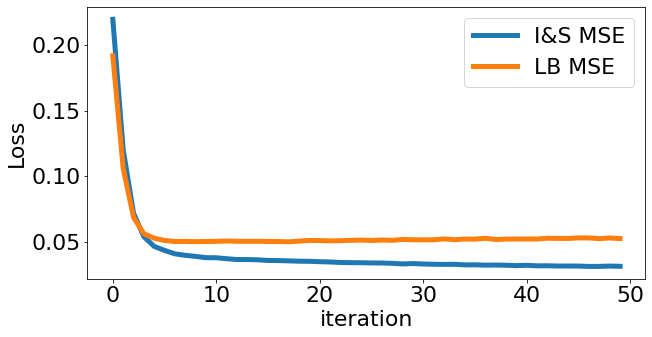

In [ ]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,5))
# plt.title("Loss During Training KL")
plt.plot(np.array(is_losses).reshape(-1, 59).mean(1),label="I&S MSE", linewidth = 5)
plt.plot(np.array(lb_losses).reshape(-1, 59).mean(1),label="LB MSE",  linewidth = 5)
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()